# 🔐 Network Intrusion Detection : CIC-IDS2017 Analysis

**Dataset:** CICIDS 2017 (Canadian Institute for Cybersecurity)  
**Goal:** Preprocess network traffic data and build a baseline anomaly detection model  

---

## 📋 Table of Contents

1. [Data Loading](#1-data-loading)
   - 1.1 Load a Single File
   - 1.2 Load & Combine All Files
   - 1.3 Class Distribution
2. [Preprocessing](#2-preprocessing)
   - 2.1 Handle Infinity & Negative Values
   - 2.2 Feature Redundancy — Correlation Analysis
   - 2.3 Feature Scaling (RobustScaler)
   - 2.4 Remove Constant Features
   - 2.5 Remove Quasi-Constant Features
3. [Machine Learning](#3-machine-learning)
   - 3.1 Prepare Labels
   - 3.2 Baseline Model (Random Forest)
   - 3.3 Evaluation

---

## 0. Imports & Configuration

Import all required libraries upfront for clarity.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
path = os.path.abspath("")+"\\MachineLearningCVE"


DATA_FOLDER = os.path.expanduser("c:\\Users\\O M E N\\source\\dev\\Stages\\federated learning\\DRL_Based_Approach_FL_Client_Selection\\implementation\\cic_data\\MachineLearningCVE")

---
## 1. Data Loading

The dataset contains one CSV file per day of the week, each capturing different attack scenarios.

### 1.1 Explore Available Files

In [2]:
# List all CSV files in the data folder
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]
print(f"Found {len(all_files)} CSV files:")
for f in all_files:
    print(f"  - {f}")

Found 8 CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv


### 1.2 Quick Inspection — Single File (Monday)

Load one file first to inspect structure, column names, and data types.

In [3]:
# Load the Monday file as a quick sanity check
monday_path = os.path.join(DATA_FOLDER, "Monday-WorkingHours.pcap_ISCX.csv")
df_monday = pd.read_csv(monday_path)

print(f"Shape: {df_monday.shape}")
print(f"Columns ({len(df_monday.columns)}): {list(df_monday.columns)}")
df_monday.head()

Shape: (529918, 79)
Columns (79): [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Coun

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
# Monday is benign-only — good baseline check
df_monday[' Label'].value_counts()

 Label
BENIGN    529918
Name: count, dtype: int64

### 1.3 Load & Combine All Files

Concatenate all daily CSV files into a single DataFrame for unified analysis.

In [5]:
# Load all CSV files and concatenate into one DataFrame
dfs = [pd.read_csv(os.path.join(DATA_FOLDER, f)) for f in all_files]
full_df = pd.concat(dfs, ignore_index=True)

print(f"Combined dataset shape: {full_df.shape}")
full_df.head()

Combined dataset shape: (2830743, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# Strip leading/trailing whitespace from all column names
full_df.columns = full_df.columns.str.strip()
print("Column names cleaned.")

Column names cleaned.


### 1.4 Class Distribution

The dataset is highly imbalanced — ~80% of traffic is benign. This will be important for model evaluation.

In [7]:
# Count and percentage of each traffic label
counts = full_df['Label'].value_counts()
percentages = full_df['Label'].value_counts(normalize=True) * 100

summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages.round(4)})
print(summary.to_string())

                              Count  Percentage (%)
Label                                              
BENIGN                      2273097         80.3004
DoS Hulk                     231073          8.1630
PortScan                     158930          5.6144
DDoS                         128027          4.5227
DoS GoldenEye                 10293          0.3636
FTP-Patator                    7938          0.2804
SSH-Patator                    5897          0.2083
DoS slowloris                  5796          0.2048
DoS Slowhttptest               5499          0.1943
Bot                            1966          0.0695
Web Attack � Brute Force       1507          0.0532
Web Attack � XSS                652          0.0230
Infiltration                     36          0.0013
Web Attack � Sql Injection       21          0.0007
Heartbleed                       11          0.0004


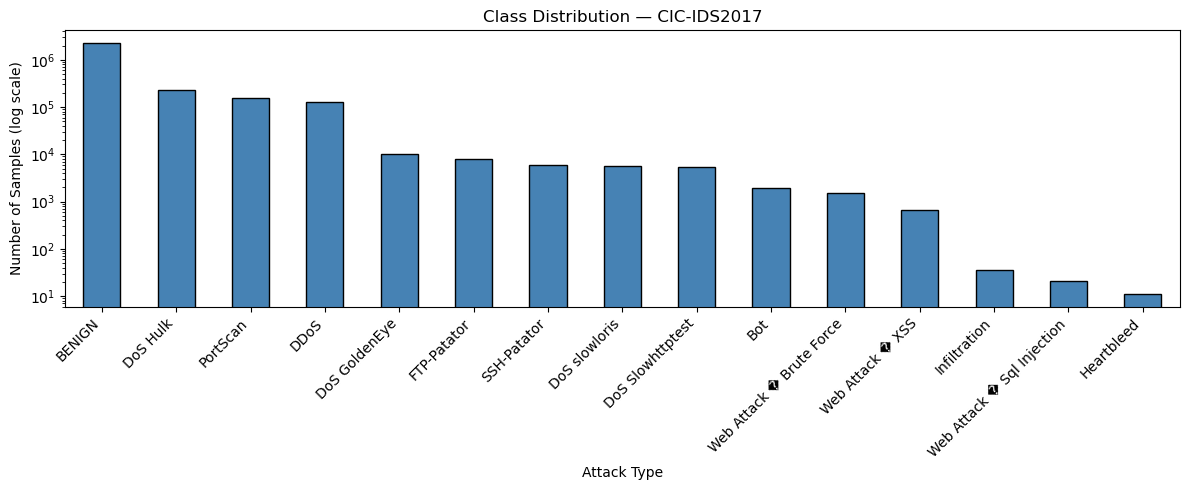

In [8]:
# Visual overview of class distribution (log scale for readability)
counts.plot(kind='bar', figsize=(12, 5), color='steelblue', edgecolor='black')
plt.title("Class Distribution — CIC-IDS2017")
plt.xlabel("Attack Type")
plt.ylabel("Number of Samples (log scale)")
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## 2. Preprocessing

Network traffic data often contains anomalies like infinity values, negative measurements, highly correlated features, and near-zero variance columns. We address each systematically.

### 2.1 Handle Infinity & Negative Values

Some features like `Flow Bytes/s` can produce ±Inf due to near-zero durations. We replace them with NaN and drop those rows. We also filter out physically impossible negative values in key metrics.

In [9]:
# --- Audit: Infinity values ---
inf_count = np.isinf(full_df.select_dtypes(include=np.number)).sum().sum()
print(f"Total Infinity values: {inf_count}")

# --- Audit: Negative values in numeric columns ---
negatives = full_df.select_dtypes(include=np.number).min()
print("\nColumns with negative minimum values:")
print(negatives[negatives < 0])

Total Infinity values: 4376

Columns with negative minimum values:
Flow Duration             -1.300000e+01
Flow Bytes/s              -2.610000e+08
Flow Packets/s            -2.000000e+06
Flow IAT Mean             -1.300000e+01
Flow IAT Max              -1.300000e+01
Flow IAT Min              -1.400000e+01
Fwd IAT Min               -1.200000e+01
Fwd Header Length         -3.221223e+10
Bwd Header Length         -1.073741e+09
Fwd Header Length.1       -3.221223e+10
Init_Win_bytes_forward    -1.000000e+00
Init_Win_bytes_backward   -1.000000e+00
min_seg_size_forward      -5.368707e+08
dtype: float64


In [10]:
# Replace ±Inf with NaN and drop those rows
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.dropna(inplace=True)

initial_shape = full_df.shape[0]

# Remove rows with negative values in columns that physically cannot be negative
cols_non_negative = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Fwd Header Length', 'min_seg_size_forward'
]
for col in cols_non_negative:
    full_df = full_df[full_df[col] >= 0]

# Final NaN cleanup after filtering
full_df.dropna(inplace=True)

print(f"Rows removed: {initial_shape - full_df.shape[0]}")
print(f"Dataset shape after cleaning: {full_df.shape}")

Rows removed: 150
Dataset shape after cleaning: (2827726, 79)


In [11]:
# Verify: check for remaining Inf or problematic negatives
inf_count = np.isinf(full_df.select_dtypes(include=np.number)).sum().sum()
print(f"Remaining Infinity values: {inf_count}")

negatives = full_df.select_dtypes(include=np.number).min()
remaining_neg = negatives[negatives < 0]
print("\nRemaining columns with negative values (may be acceptable):")
print(remaining_neg)

Remaining Infinity values: 0

Remaining columns with negative values (may be acceptable):
Flow IAT Min              -14.0
Fwd IAT Min               -12.0
Init_Win_bytes_forward     -1.0
Init_Win_bytes_backward    -1.0
dtype: float64


### 2.2 Feature Redundancy — Correlation Analysis

Highly correlated features (|r| > 0.95) are redundant and can hurt model interpretability and training speed. We keep only one feature from each correlated pair.

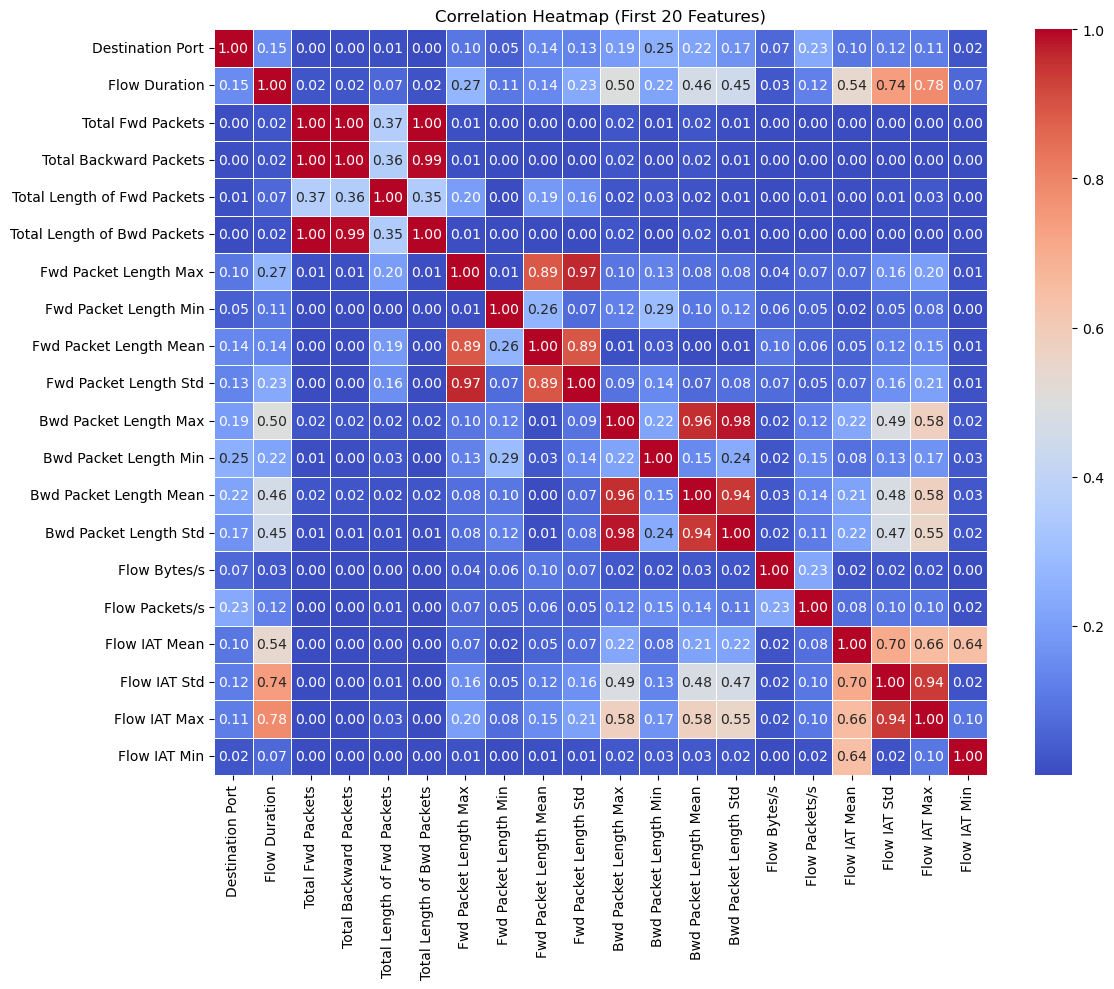

In [12]:
# Compute absolute correlation matrix for numeric features
corr_matrix = full_df.corr(numeric_only=True).abs()

# Visualize the first 20 features for readability
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix.iloc[:20, :20],
    annot=True, fmt=".2f",
    cmap='coolwarm', linewidths=0.5
)
plt.title("Correlation Heatmap (First 20 Features)")
plt.tight_layout()
plt.show()

In [13]:
# Identify columns where any other column has correlation > 0.95
# We use the upper triangle to avoid double-counting pairs
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

full_df_reduced = full_df.drop(columns=to_drop)

print(f"Features reduced from {full_df.shape[1]} to {full_df_reduced.shape[1]}")
print(f"Dropped {len(to_drop)} correlated features: {to_drop}")

Features reduced from 79 to 54
Dropped 25 correlated features: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Packet Length Std', 'SYN Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Idle Mean', 'Idle Max', 'Idle Min']


### 2.3 Feature Scaling — RobustScaler

`RobustScaler` uses the median and IQR instead of mean/std, making it resilient to outliers — crucial for network traffic data where attack traffic (e.g., DDoS) creates extreme spikes.

In [14]:
# Separate features and labels
X = full_df_reduced.drop('Label', axis=1)
y = full_df_reduced['Label']

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for ease of use
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled feature matrix shape: {X_scaled_df.shape}")
X_scaled_df.head()

Scaled feature matrix shape: (2827726, 53)


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,...,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Std
0,140.474359,-0.009672,0.000000,-0.284091,-0.413333,0.111111,-0.636364,-0.282143,0.000000,23.989648,...,0.0,-0.026608,0.000000,0.0,-0.333333,0.0,0.0,0.0,0.0,0.0
1,140.958974,-0.009639,-0.333333,-0.318182,-0.413333,0.111111,-0.636364,-0.260714,0.077922,0.633480,...,0.0,-0.027096,1.088983,-0.5,-0.333333,0.0,0.0,0.0,0.0,0.0
2,140.961538,-0.009657,-0.333333,-0.318182,-0.413333,0.111111,-0.636364,-0.260714,0.077922,1.358064,...,0.0,-0.027096,1.088983,-0.5,-0.333333,0.0,0.0,0.0,0.0,0.0
3,118.348718,-0.009663,-0.333333,-0.318182,-0.413333,0.111111,-0.636364,-0.260714,0.077922,2.091620,...,0.0,-0.026852,1.398305,-0.5,-0.333333,0.0,0.0,0.0,0.0,0.0
4,140.469231,-0.009672,0.000000,-0.284091,-0.413333,0.111111,-0.636364,-0.282143,0.000000,23.989648,...,0.0,-0.026730,0.000000,0.0,-0.333333,0.0,0.0,0.0,0.0,0.0


### 2.4 Remove Constant Features

Features with only 1 unique value carry no information and should be removed.

In [15]:
# Identify constant columns (only 1 unique value)
constant_cols = [col for col in X_scaled_df.columns if X_scaled_df[col].nunique() <= 1]

print(f"Detected {len(constant_cols)} constant features to remove:")
print(constant_cols)

X_no_constant = X_scaled_df.drop(columns=constant_cols)
print(f"\nFeature count after removal: {X_no_constant.shape[1]}")

Detected 8 constant features to remove:
['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

Feature count after removal: 45


### 2.5 Remove Quasi-Constant Features

Features that are the same value in >99.5% of rows are effectively uninformative. `VarianceThreshold` removes them automatically.

In [16]:
# Threshold: variance below p*(1-p) where p=0.995 means feature is same in 99.5% of rows
threshold = 0.005 * (1 - 0.005)

selector = VarianceThreshold(threshold=threshold)
X_final = selector.fit_transform(X_no_constant)

final_features = X_no_constant.columns[selector.get_support()]
X_final_df = pd.DataFrame(X_final, columns=final_features)

print(f"Final feature count after removing quasi-constant features: {X_final_df.shape[1]}")

Final feature count after removing quasi-constant features: 43


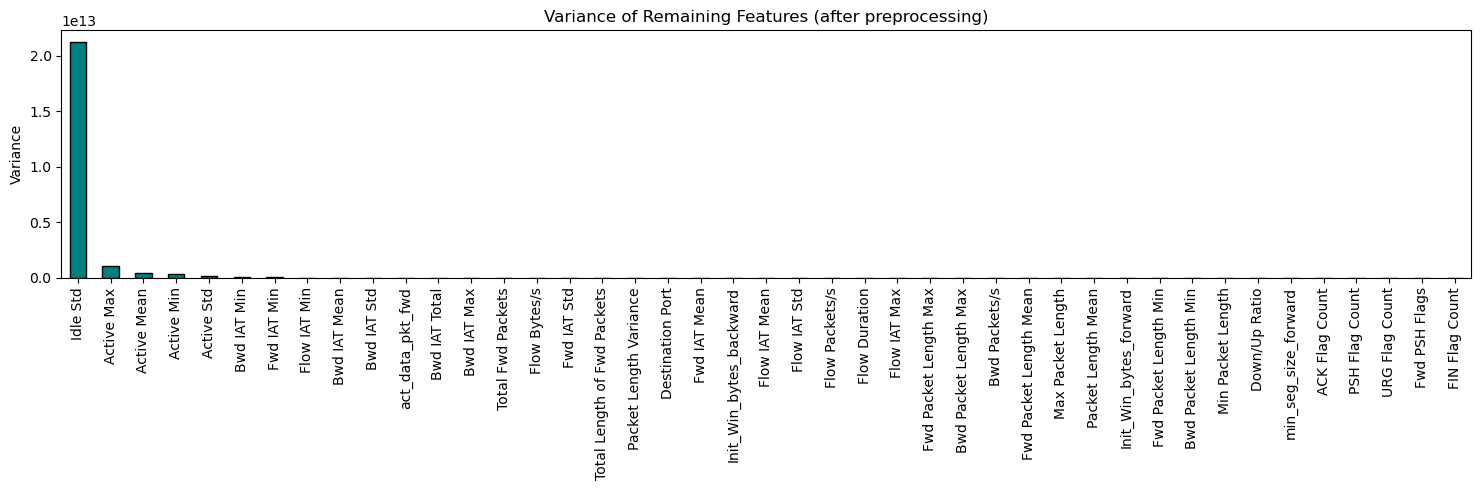

In [17]:
# Visualize variance of remaining features
X_final_df.var().sort_values(ascending=False).plot(
    kind='bar', figsize=(15, 5), color='teal', edgecolor='black'
)
plt.title("Variance of Remaining Features (after preprocessing)")
plt.ylabel("Variance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# Summary of preprocessing pipeline
print("=" * 45)
print("        PREPROCESSING SUMMARY")
print("=" * 45)
print(f"  Original features     : {full_df.shape[1] - 1}")
print(f"  After correlation drop: {full_df_reduced.shape[1] - 1}")
print(f"  After constant removal: {X_no_constant.shape[1]}")
print(f"  Final feature count   : {X_final_df.shape[1]}")
print(f"  Total rows retained   : {X_final_df.shape[0]:,}")
print("=" * 45)

        PREPROCESSING SUMMARY
  Original features     : 78
  After correlation drop: 53
  After constant removal: 45
  Final feature count   : 43
  Total rows retained   : 2,827,726


---
## 3. Machine Learning

We start with a **binary classification** task: **BENIGN (0) vs. ATTACK (1)**. This is the anomaly detection framing, useful as an initial detector before identifying specific attack types.

### 3.1 Prepare Labels

We encode the target as binary: `0 = BENIGN`, `1 = any attack`.

In [19]:
# Binary label: 0 = BENIGN, 1 = ATTACK (any)
y_binary = (y != 'BENIGN').astype(int)

print("Binary label distribution:")
print(y_binary.value_counts().rename({0: 'BENIGN', 1: 'ATTACK'}).to_string())

Binary label distribution:
Label
BENIGN    2271170
ATTACK     556556


### 3.2 Train/Validation Split & Baseline Model

We use an 80/20 stratified split to preserve the class ratio. The baseline model is a **Random Forest** with shallow depth for speed — a good starting point before hyperparameter tuning.

In [20]:
# Stratified split to maintain class balance in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X_final_df, y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

print(f"Training set  : {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")

Training set  : 2,262,180 samples
Validation set: 565,546 samples


In [21]:
# Baseline Random Forest — shallow trees for speed, can tune later
baseline = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

baseline.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


### 3.3 Evaluation

We evaluate on the held-out validation set. For intrusion detection, **recall on the attack class (1)** is the most critical metric — we want to miss as few attacks as possible.

In [22]:
# Classification report: precision, recall, F1 per class
y_pred = baseline.predict(X_val)

print("Classification Report (0 = BENIGN, 1 = ATTACK):")
print(classification_report(y_val, y_pred, target_names=['BENIGN', 'ATTACK']))

Classification Report (0 = BENIGN, 1 = ATTACK):
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454235
      ATTACK       1.00      0.98      0.99    111311

    accuracy                           1.00    565546
   macro avg       1.00      0.99      0.99    565546
weighted avg       1.00      1.00      1.00    565546



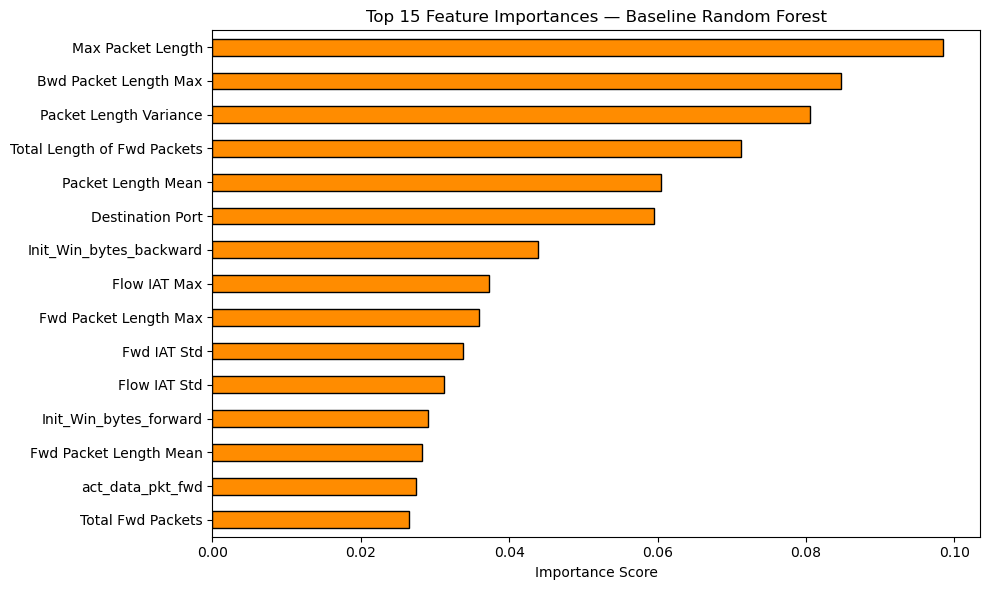

In [23]:
# Top 15 most important features for the baseline model
importances = pd.Series(baseline.feature_importances_, index=X_final_df.columns)
importances.sort_values(ascending=False).head(15).plot(
    kind='barh', figsize=(10, 6), color='darkorange', edgecolor='black'
)
plt.title("Top 15 Feature Importances — Baseline Random Forest")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# import sys
# !{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [25]:
# import torch
# print(torch.__version__)
# print("CUDA available:", torch.cuda.is_available())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Configuration
input_dim = 43  # reduced feature count
latent_dim = 100 

class AdvGenerator(nn.Module):
    def __init__(self, input_dim):
        super(AdvGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, input_dim),
            nn.Tanh() # Perturbation range [-1, 1]
        )

    def forward(self, x, mask, epsilon=0.05):
        # Generate perturbation
        perturbation = self.main(x)
        # Apply mask: only change mutable features
        # epsilon: controls the 'strength' of the attack
        x_adv = x + (perturbation * mask * epsilon)
        return x_adv

class AdvDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(AdvDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1) # Output raw score for WGAN
        )

    def forward(self, x):
        return self.main(x)

In [27]:
import pandas as pd

feature_names = X_train.columns  # keep same order used to train baseline

def train_advgan(generator, discriminator, target_model, dataloader, epochs=50, alpha=10.0):
    optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for i, (real_attacks, _) in enumerate(dataloader):
            real_attacks = real_attacks.to(device)  # ✅ move batch to GPU/CPU

            # --- 1) Train Discriminator ---
            optimizer_D.zero_grad()
            adv_attacks_detached = generator(real_attacks, mask).detach()

            loss_D = -torch.mean(discriminator(real_attacks)) + torch.mean(discriminator(adv_attacks_detached))
            loss_D.backward()
            optimizer_D.step()

            # --- 2) Train Generator ---
            optimizer_G.zero_grad()
            adv_attacks = generator(real_attacks, mask)

            loss_gan = -torch.mean(discriminator(adv_attacks))

            # ✅ Black-box query with feature names
            with torch.no_grad():
                adv_np = adv_attacks.detach().cpu().numpy()
                adv_df = pd.DataFrame(adv_np, columns=feature_names)
                probs_benign = target_model.predict_proba(adv_df)[:, 0]  # P(class=0)
                probs_benign = torch.tensor(probs_benign, device=device, dtype=torch.float32)

            loss_adv = torch.mean(1.0 - probs_benign)
            total_loss_G = loss_gan + alpha * loss_adv

            total_loss_G.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss adv: {loss_adv.item():.4f}")

In [28]:
mask_attack = (y_train.to_numpy() == 1)
X_attacks_only = X_train.iloc[mask_attack]

In [29]:
from torch.utils.data import DataLoader, TensorDataset

# Convert attacks to tensors
X_attacks_tensor = torch.tensor(X_attacks_only.to_numpy(), dtype=torch.float32)

# Dummy labels (not used by GAN, just to fit TensorDataset)
y_attacks_tensor = torch.ones((X_attacks_tensor.size(0), 1), dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_attacks_tensor, y_attacks_tensor)
attack_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

# Feature mutability mask (currently all mutable)
mask = torch.ones(X_attacks_tensor.size(1), dtype=torch.float32)

In [30]:
X_attacks_tensor = torch.tensor(X_attacks_only.to_numpy(), dtype=torch.float32)
y_attacks_tensor = torch.ones(len(X_attacks_tensor), dtype=torch.float32)

train_dataset = TensorDataset(X_attacks_tensor, y_attacks_tensor)
attack_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mask = torch.ones(X_attacks_tensor.shape[1], dtype=torch.float32)

In [31]:
# Initialize Models
generator = AdvGenerator(input_dim=43)
discriminator = AdvDiscriminator(input_dim=43)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
mask = mask.to(device)

# Start Training
# Note: target_model is your 'baseline' RandomForest
train_advgan(generator, discriminator, baseline, attack_loader, epochs=30)

Epoch [1/30] | Loss D: -0.0020 | Loss adv: 0.6365
Epoch [2/30] | Loss D: 0.0020 | Loss adv: 0.6460
Epoch [3/30] | Loss D: -0.0005 | Loss adv: 0.7896
Epoch [4/30] | Loss D: 0.0020 | Loss adv: 0.6900
Epoch [5/30] | Loss D: -0.0012 | Loss adv: 0.7016
Epoch [6/30] | Loss D: -0.0037 | Loss adv: 0.6480
Epoch [7/30] | Loss D: 0.0020 | Loss adv: 0.7061
Epoch [8/30] | Loss D: 0.0020 | Loss adv: 0.6623
Epoch [9/30] | Loss D: 0.0005 | Loss adv: 0.6118
Epoch [10/30] | Loss D: 0.0000 | Loss adv: 0.6183
Epoch [11/30] | Loss D: 0.0005 | Loss adv: 0.6603
Epoch [12/30] | Loss D: -0.0020 | Loss adv: 0.6545
Epoch [13/30] | Loss D: 0.0010 | Loss adv: 0.6527
Epoch [14/30] | Loss D: -0.0007 | Loss adv: 0.7133
Epoch [15/30] | Loss D: 0.0000 | Loss adv: 0.6787
Epoch [16/30] | Loss D: 0.0001 | Loss adv: 0.6831
Epoch [17/30] | Loss D: 0.0010 | Loss adv: 0.6552
Epoch [18/30] | Loss D: -0.0005 | Loss adv: 0.5936
Epoch [19/30] | Loss D: -0.0002 | Loss adv: 0.5991
Epoch [20/30] | Loss D: 0.0005 | Loss adv: 0.7000
E

In [32]:
### 

In [33]:
def test_evasion(gen, target_model, test_df, labels, mask_tensor):
    gen.eval()
    
    # FIX: Ensure labels and test_df are aligned by resetting index or using .values
    # We use .values on the boolean check to bypass Pandas index alignment
    attack_mask = (labels.values == 1) 
    
    # Filter only attacks
    real_attacks_np = test_df.values[attack_mask]
    real_attacks = torch.tensor(real_attacks_np).float().to(device)
    
    with torch.no_grad():
        # Generate adversarial versions
        adv_attacks = gen(real_attacks, mask_tensor, epsilon=0.05).cpu().numpy()
    
    # Predict using the baseline Random Forest
    preds = target_model.predict(adv_attacks)
    
    evasions = np.sum(preds == 0)
    esr = (evasions / len(adv_attacks)) * 100
    
    print(f"--- Adversarial Evaluation ---")
    print(f"Total Attack Samples tested: {len(adv_attacks)}")
    print(f"Successful Evasions: {evasions}")
    print(f"Evasion Success Rate (ESR): {esr:.2f}%")
    
    return adv_attacks

# Run the test again
adv_samples = test_evasion(generator, baseline, X_val, y_val, mask)

--- Adversarial Evaluation ---
Total Attack Samples tested: 111311
Successful Evasions: 50153
Evasion Success Rate (ESR): 45.06%


c:\Users\O M E N\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


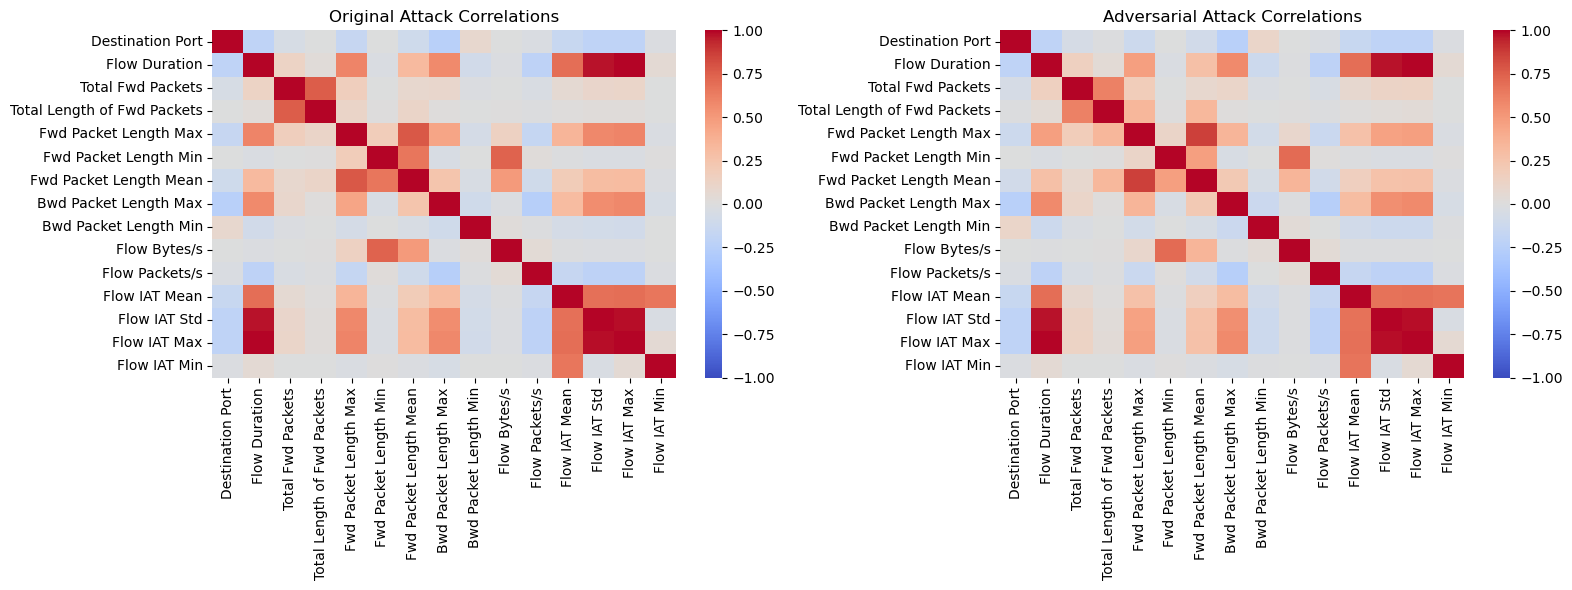

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Take a subset of features to visualize
features_to_plot = X_final_df.columns[:15]

# 2. Filter Real Attacks safely using .values to avoid IndexingError
# This ensures we only look at the 'Attack' rows from the training set
attack_mask = (y_train.values == 1)
real_attacks_subset = X_train.iloc[attack_mask][features_to_plot]

# 3. Calculate Correlations
real_corr = real_attacks_subset.corr()
# For adv_samples, we create a temporary DF with the correct column names
adv_corr = pd.DataFrame(adv_samples[:, :15], columns=features_to_plot).corr()

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Original Attack Correlations")

sns.heatmap(adv_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Adversarial Attack Correlations")

plt.tight_layout()
plt.show()

In [35]:
import torch

# Create a directory for models if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the Generator and Discriminator
torch.save(generator.state_dict(), 'models/advgan_generator.pth')
torch.save(discriminator.state_dict(), 'models/advgan_discriminator.pth')

print("GAN models saved successfully.")

GAN models saved successfully.


In [36]:
import joblib

# Save the Random Forest baseline
joblib.dump(baseline, 'models/rf_baseline.joblib')

# Save the Scaler (Crucial for future inference!)
joblib.dump(scaler, 'models/robust_scaler.joblib')

# Save the Label mapping or column names to be safe
joblib.dump(list(X_final_df.columns), 'models/feature_columns.joblib')

print("ML models and Scaler saved successfully.")

ML models and Scaler saved successfully.


In [37]:


import torch
import joblib

# 1. Load the ML components
scaler = joblib.load('models/robust_scaler.joblib')
baseline = joblib.load('models/rf_baseline.joblib')
feature_cols = joblib.load('models/feature_columns.joblib')

# 2. Re-initialize and load the GAN
# (Make sure the AdvGenerator class is defined in your script)
generator = AdvGenerator(input_dim=43)
generator.load_state_dict(torch.load('models/advgan_generator.pth'))
generator.eval() # Set to evaluation mode

print("All research components reloaded and ready!")

All research components reloaded and ready!


C:\Users\O M E N\AppData\Local\Temp\ipykernel_9640\2991277434.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('models/advgan_genera

In [38]:
# Convert adversarial samples to a DataFrame
adv_samples_df = pd.DataFrame(adv_samples, columns=X_final_df.columns)

# We know these are all attacks, so labels are 1
adv_labels = pd.Series([1] * len(adv_samples))

# Combine original training data with adversarial samples
X_train_robust = pd.concat([X_train, adv_samples_df], ignore_index=True)
y_train_robust = pd.concat([y_train, adv_labels], ignore_index=True)

print(f"New training size: {len(X_train_robust)} (Added {len(adv_samples)} adversarial samples)")

New training size: 2373491 (Added 111311 adversarial samples)


In [39]:
# Train a new Random Forest on the augmented data
robust_baseline = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1)
robust_baseline.fit(X_train_robust, y_train_robust)

print("Robust Model Trained.")

Robust Model Trained.


In [41]:
# Before calling the function, ensure the mask is on the device
mask = mask.to(device)

def test_evasion(gen, target_model, test_df, labels, mask_tensor):
    gen.eval()
    
    # Ensure the generator itself is on the correct device
    gen.to(device)
    
    # 1. Filter attacks and move to device
    attack_mask = (labels.values == 1)
    real_attacks_np = test_df.values[attack_mask]
    
    # Explicitly send to device
    real_attacks = torch.tensor(real_attacks_np).float().to(device)
    
    # Ensure mask_tensor is on the same device as real_attacks
    mask_tensor = mask_tensor.to(device)
    
    with torch.no_grad():
        # Generate adversarial versions
        # Now real_attacks, mask_tensor, and gen are all on 'device'
        adv_attacks = gen(real_attacks, mask_tensor, epsilon=0.05).cpu().numpy()
    
    # 2. Predict using the ROBUST model
    preds = target_model.predict(adv_attacks)
    
    evasions = np.sum(preds == 0)
    esr = (evasions / len(adv_attacks)) * 100
    
    print(f"--- Adversarial Evaluation (Robust Model) ---")
    print(f"Total Attack Samples tested: {len(adv_attacks)}")
    print(f"Successful Evasions: {evasions}")
    print(f"New Evasion Success Rate (ESR): {esr:.2f}%")
    
    return adv_attacks

# Run the test again with the robust_baseline
new_adv_samples = test_evasion(generator, robust_baseline, X_val, y_val, mask)

--- Adversarial Evaluation (Robust Model) ---
Total Attack Samples tested: 111311
Successful Evasions: 1
New Evasion Success Rate (ESR): 0.00%


c:\Users\O M E N\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


C:\Users\O M E N\AppData\Local\Temp\ipykernel_9640\2879506652.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Mean_Perturbation', y='Feature', palette='magma')


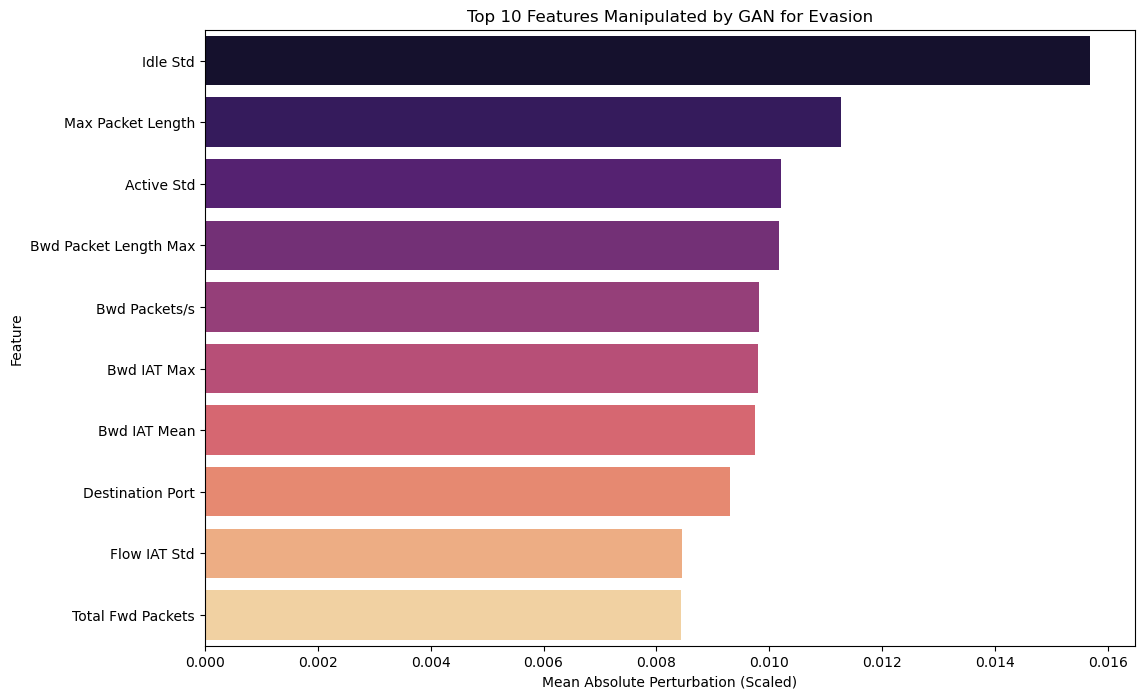

Top 5 Weakest Links (Most Manipulated Features):
                  Feature  Mean_Perturbation
42               Idle Std           0.015688
26      Max Packet Length           0.011277
39             Active Std           0.010214
7   Bwd Packet Length Max           0.010171
24          Bwd Packets/s           0.009825


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Safely filter real attacks using .values to bypass the indexing error
attack_mask = (y_val.values == 1)
real_attacks_np = X_val.values[attack_mask]

# 2. Calculate the absolute difference
# adv_samples contains the generated adversarial traffic from your first test
differences = np.abs(adv_samples - real_attacks_np)

# 3. Calculate the mean perturbation per feature
mean_diffs = np.mean(differences, axis=0)

# 4. Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_final_df.columns,
    'Mean_Perturbation': mean_diffs
}).sort_values(by='Mean_Perturbation', ascending=False)

# 5. Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(10), x='Mean_Perturbation', y='Feature', palette='magma')
plt.title("Top 10 Features Manipulated by GAN for Evasion")
plt.xlabel("Mean Absolute Perturbation (Scaled)")
plt.show()

# 6. Print the top 5 for your notes
print("Top 5 Weakest Links (Most Manipulated Features):")
print(importance_df.head(5))